In [1]:
#========================================================================
#
# Copyright 2019 Science Technology Facilities Council
# Copyright 2019 University of Manchester
#
# This work is part of the Core Imaging Library developed by Science Technology
# Facilities Council and University of Manchester
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#         http://www.apache.org/licenses/LICENSE-2.0.txt
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
#=========================================================================

<h1><center>Primal Dual Hybrid Gradient Algorithm: Part I (Denoising) </center></h1>

This is the first part of the Primal Dual Hybrid Gradient Algorithm demos that will focus on __Denoising__ applications. The second part will cover __Tomography__ reconstruction applications. 

In this demo you will learn how to use the __Primal Dual Hybrid Gradient (PDHG)__ algorithm introduced in [Chambolle2011, Esser, Zhu Chan]. In particular, we will consider three different data fitting terms that are associated with data corrupted with __Gaussian__, __Poisson__ and __Salt & Pepper__ noise. Furthermore, we demonstrate how to use gradient-based priors in our minimisation problem such as:

- Tikhonov regularisation
- Total Variation (TV) regulariation
- Total Generalised Variatin (TGV) regularisation

Overall, we consider the following the minimisation problem that covers the cases below:

$$ \underset{u}{\operatorname{argmin}}
\begin{cases}
\frac{1}{2}\| g - u \|^{2}\\[5pt]
\| g - u \|_{1}\\[5pt]
\sum u - g\log(u) + \mathbb{I}_{\{u>0\}}
\end{cases} + \quad
\begin{cases}
\alpha \,\|\nabla u\|^{2} \\[5pt]
\alpha \,\mathrm{TV}(u) = \alpha\,\|\nabla u\|_{2,1}\\[5pt]
\mathrm{TGV}(u) = \underset{w}{\operatorname{argmin}}\alpha\,\|\nabla u - w\|_{2,1} + \beta\,\|\mathcal{E}w\|_{2,1}
\end{cases}
$$

## Learning objectives

1. Formulate easily different minimiation problems with a __mix-match__ framework between data fitting terms and regularisers.
1. Simulate denoising problems for Gaussian and Salt-Pepper noise.
1. Add gradient-based regularisers such as the Total variation and Tikhonov regularisation.
1. Learn how to setup and run PDHG algorithm, using the __BlockFramework__.

## Prerequisites

- ImageData, BlockDataContainer.
- ImageGeometry, BlockGeometry.
- Gradient Operator, BlockOperator

<h1><center> Example: Gaussian Denoising</center></h1>   
<img src="images/shapes_all.jpeg"  width="800"/>

<h1><center> Overview of PDHG algorithm</center></h1>    

The PDHG algorithm aims to solve problems of the form below:

<a id='PDHG'></a>
$$
\begin{equation}
\min_{u} \mathcal{F}(K u) + \mathcal{G}(u)
\label{min_problem} \tag{1}
\end{equation}
$$

where: 

1. $K$ is a continuous linear operator acting from a space X to another space Y :

   $$K : X \rightarrow Y \quad \mbox{ with operator norm defined as }\quad \| K \| = \max\{ \|K x\|_{Y} : \|x\|_{X}\leq 1 \}.$$
      
   **Example**:  If $K$ is a projection operator  think :
   
    - X as your ImageGeometry, i.e., $\mathbb{R}^{n} $
    - Y as your AcquisitionGeometry, i.e., $\mathbb{R}^{m} $
    - $K \in \mathbb{R}^{m \times n} $ and  $\|K\|$ is computed using the [PowerMethod](https://en.wikipedia.org/wiki/Power_iteration). ( We will use it later. )
    
   **Example**:  If $K$ is a gradient operator, i.e., $\nabla = ( \partial_{y}, \partial_{x} )$ where $\partial_{y}, \partial_{x}$ represent finite difference operators along the direction y and x, you can think :
   
    - X as your ImageGeometry, the image - space, $\mathbb{R}^{n\times m} $
    - Y as your BlockGeometry, i.e., $(\mathbb{R}^{n\times m}, \mathbb{R}^{n\times m}) $
    - $\|\nabla\|$ = $\sqrt{8}$
    
        
2. $\mathcal{F}$, $\mathcal{G}$ are convex functionals
    
    - $\mathcal{F}: Y \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: X \rightarrow \mathbb{R}$
    

3. The PDHG algorithm is described below :
    
<center> Choose step-sizes $\tau$, $\sigma$, such that $\tau\sigma\|K\|^{2}<1$ </center> 
<center> Choose $\theta\in[0,1]$ </center>
<center> Let $(x^{0}, y^{0})\in X\times Y$ and $\overline{x}^{0} = x^{0}$ </center>
<br>
\begin{align}
    y^{n+1}  & = ( I + \sigma \partial F^{*} ) ^ {-1} ( y^{n} + \sigma K \overline{x}^{n} )\quad \mbox{ (Dual Problem)}\tag{1}\\[10pt]
    x^{n+1}  & = ( I + \tau \partial G ) ^ {-1} ( x^{n} - \tau K^{*} \overline{x}^{n} )\quad \mbox{ (Primal Problem) }\tag{2}\\[10pt]
    \overline{x}^{n+1} & = x^{n+1} + \theta ( x^{n+1} - x^{n} )\quad\mbox{ (Over-relaxation step) }
\end{align}
    
__**REMINDER**__: Let $\lambda>0$ and $f$ a convex function. Then

$$
z = (I + \lambda\partial f)^{-1}(x) : = \mathbf{\underset{z}{\operatorname{\textbf{argmin}}} \{\frac{1}{2}\|z - x \|^{2} + \lambda f(z) \}} := \mbox{prox}_{\tau f}(x) \quad (\mbox{Proximal Operator})
$$
 
__**Note**__: We assume that proximal operators have a closed form solution or can be solved efficiently using an iterative algorithm.

## Examples: Proximal Operator 

Below, we present how the __Proximal operator__ looks like for 3 different functions:

- For an Indicator function:  $$f_{1}(x) = \mathbb{I}_{[\alpha, \beta]}(x) = 
\begin{cases}
0, & \mbox{ if } x\in[\alpha, \beta]\\
\infty, & otherwise
\end{cases}\quad\Longrightarrow \quad\mathrm{prox}_{\tau f_{1}}(x) = \min\{ \max\{ x, a\}, b\} = 
\begin{cases} 
a,\, \mbox{ if } x\leq a\\
x,\, \mbox{ if } a\leq x\leq b\\
b, \, \mbox{ if } x\geq b\\
\end{cases}$$


- $f_{2}(x) = \frac{1}{2} x^{2} \quad \Longleftrightarrow \quad\mathrm{prox}_{\tau f_{2}}(x) = \frac{x}{1+\tau}$ 
- $f_{3}(x) = |x| \quad \Longrightarrow \quad\mathrm{prox}_{\tau f_{3}}(x) = \max\{ |x| - \tau, 0\}\mathrm{sgn}(x) = \begin{cases} 
x - \tau ,\, \mbox{ if } x\geq \tau\\
0,\, \mbox{ if } |x|\leq \tau\\
x + \tau, \, \mbox{ if } x\leq -\tau\\
\end{cases}$

For a detailed list of proximal operators, you can see [Proximity Operators](http://proximity-operator.net/scalarfunctions.html).

In [2]:
# Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ccpi.framework import VectorData, TestData, ImageData
from ccpi.optimisation.functions import L2NormSquared, L1Norm, IndicatorBox,\
                                        MixedL21Norm, ZeroFunction, BlockFunction, KullbackLeibler
from ccpi.optimisation.algorithms import PDHG
from ccpi.optimisation.operators import Gradient, Identity, BlockOperator, SymmetrizedGradient, ZeroOperator

import sys, os
import numpy as np
import matplotlib.pyplot as plt
# from show_utilities import show, show2D
from skimage.measure import compare_psnr

from utilities import islicer
from utilities.show_utilities import show, show2D

In [3]:
# Create a vector
x = VectorData(np.linspace(-10,10,200))

# Define Indicator Function, L2NormSquared, L1Norm
f1 = IndicatorBox(lower = -5, upper = 5)
f2 = 0.5 * L2NormSquared()
f3 = L1Norm()

In [4]:
# Get proximal methods. Each Function defined above is Class that contains a proximal method
prox_f1 = f1.proximal
prox_f2 = f2.proximal
prox_f3 = f3.proximal

# Compute proximal operator for each function: prox_{\tau f}(x)
res_proximal_f1 = prox_f1(x, 10)
res_proximal_f2 = prox_f2(x, 5)
res_proximal_f3 = prox_f3(x, 2.5)

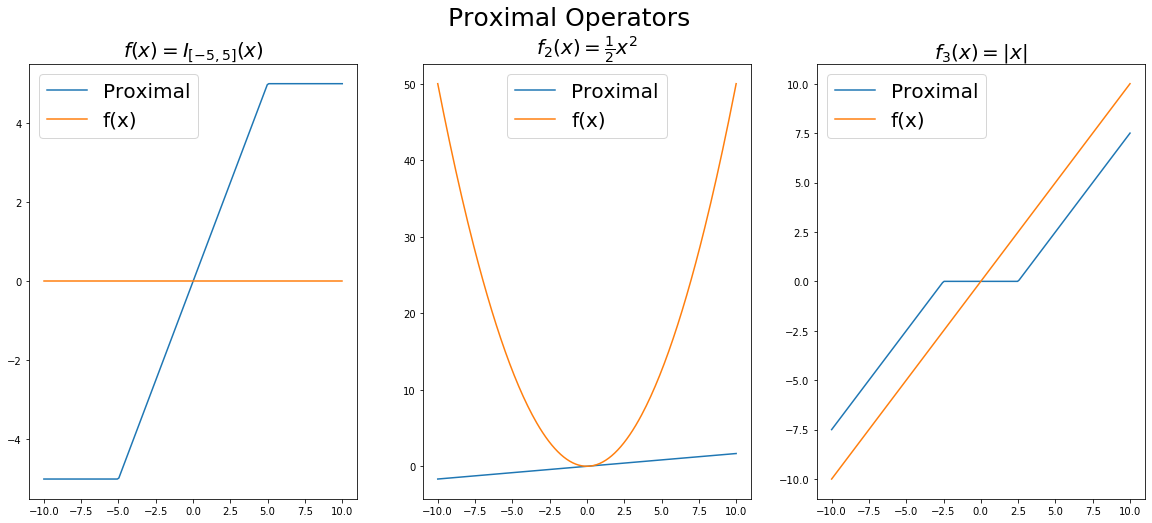

In [5]:
# Show results
plt.figure(figsize=(20,8))

plt.subplot(131)
plt.plot(x.as_array(), res_proximal_f1.as_array())
plt.plot(x.as_array(), x.as_array()*0 )
plt.legend(['Proximal', 'f(x)'], fontsize='20')
plt.title(r'$ f(x) = I_{[ -5, 5 ]}(x)$', fontsize = '20')

plt.subplot(132)
plt.plot(x.as_array(), res_proximal_f2.as_array())
plt.plot(x.as_array(), 0.5 * x.as_array()**2)
plt.legend(['Proximal', 'f(x)'], fontsize='20')
plt.title(r'$ f_{2}(x) = \frac{1}{2}x^{2}$', fontsize = '20')

plt.subplot(133)
plt.plot(x.as_array(), res_proximal_f3.as_array())
plt.plot(x.as_array(), x.as_array())
plt.legend(['Proximal', 'f(x)'], fontsize='20')
plt.title(r'$ f_{3}(x) = |x|$', fontsize = '20')

plt.suptitle('Proximal Operators',  fontsize = '25')
plt.show()

# Total Variation Denoising

We start with the well-known _ROF_ [add ref] model, where the data is corrupted with additive Gaussian white noise and the L$^{1}$ norm of the gradient is used for a regulariser. Therefore The minimisation problem we would like to solve is described below:

<a id='ROF'></a>
$$ \hat{u} \in\underset{u}{\operatorname{argmin}}\frac{1}{2}\| u - g \|^{2} + \alpha\,\mbox{TV}(u).$$

 - g is a noisy image corrupted with Gaussian noise.
 - $\frac{1}{2}\| u - g \|^{2}$: is a data-fitting term suitable for Gaussian noise.
 - $\mbox{TV}(u) = \|\nabla u\|_{2,1}$: is an edge preserving regulariser.
 - $\alpha$: regularising parameter that measures a trade-off between the fidelity and the regulariser terms.
 
Let's load a simulated test image and add Gaussian noise. Since, we will consider different noise statistics, we present the cases also for *salt & pepper* and *Poisson* noise. The Framework provides a number of test images:

- BOAT = 'boat.tiff'
- CAMERA = 'camera.png'
- PEPPERS = 'peppers.tiff'
- RESOLUTION_CHART = 'resolution_chart.tiff'
- SHAPES = 'shapes.png' (Courtesy K.Papafitsoros)

<a id='TestData'></a>

In [6]:
# Load TestData
loader = TestData(data_dir=os.path.join(sys.prefix, 'share','ccpi'))
data = loader.load(TestData.SHAPES, size=(256,256))

# Get image geometry from the data
ig = data.geometry

# Create noisy data. Change noise for different noise
noise = 'gaussian' #'gaussian', 'poisson', 's&p'

if noise == 's&p':
    n1 = TestData.random_noise(data.as_array(), mode = noise, salt_vs_pepper = 0.9, amount=0.2)
elif noise == 'poisson':
    scale = 5
    n1 = TestData.random_noise( data.as_array()/scale, mode = noise, seed = 10)*scale
elif noise == 'gaussian':
    n1 = TestData.random_noise(data.as_array(), mode = noise, seed = 10)
else:
    raise ValueError('Unsupported Noise ', noise)
  
# Allocate space for noisy_data
noisy_data = ig.allocate()
noisy_data.fill(n1)

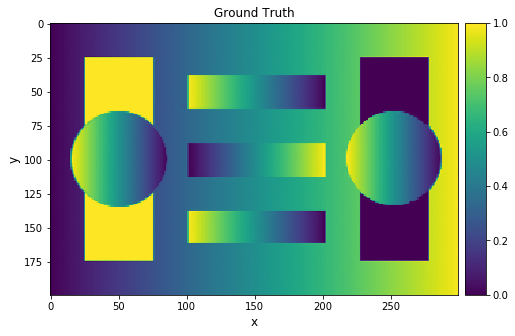

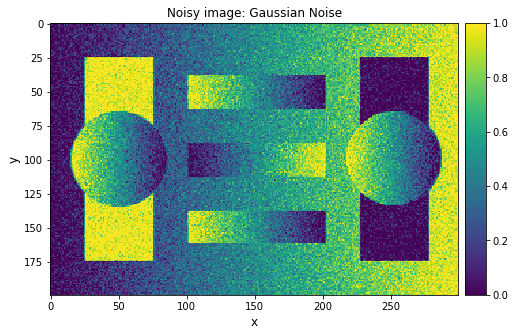

In [7]:
show(data, 'Ground Truth')
show(noisy_data, 'Noisy image: Gaussian Noise')

<a id='PDHG_implicit'></a>
Let's go back to the [PDHG](#PDHG) algorithm. In order to solve the [ROF](#ROF) problem using PDHG, we need to expresse our minimisation problem 

$$ \underset{u}{\operatorname{argmin}}\frac{1}{2}\| u - g \|^{2} + \alpha\,\|\nabla u\|_{2,1}$$

in the (primal) form

$$ \underset{x\in X}{\operatorname{argmin}} F ( K x ) + G (x), $$ where

  - $K : X \rightarrow Y $ is a linear operator.

  - $\mathcal{F}: Y \rightarrow \mathbb{R}$,$\,\,$ $\mathcal{G}: X \rightarrow \mathbb{R}$ convex functions.


1. Let $ K = \nabla $, where $\nabla : \mathbb{R}^{n\times m} \rightarrow (\mathbb{R}^{n\times m}, \mathbb{R}^{n\times m})$. $\,$ Hence, $X = \mathbb{R}^{n\times m} \mbox{ and } Y = (\mathbb{R}^{n\times m}, \mathbb{R}^{n\times m})$.

1. Let $F: Y \rightarrow \mathbb{R}$ with $$F(z_{1}) = \alpha \|z_{1}\|_{2,1} = \alpha \sum \sqrt{(z_{1}^{1})^{2} + (z_{1}^{2})^{2} }.$$
</br>
1. Let $G: X \rightarrow \mathbb{R}$ with $$G(z_{2}) = \frac{1}{2} \|z_{2} - g\|_{2}^{2} = \frac{1}{2} \sum (z_{2} - g)^{2}.$$

Then, if x = u, we write:

$$ \underset{x\in X}{\operatorname{argmin}} F(Kx) + G(x) =  \underset{u\in \mathbb{R}^{n\times m}}{\operatorname{argmin}} F(\nabla u) + G(u) = \underset{u\in \mathbb{R}^{n\times m}}{\operatorname{argmin}} \alpha \|\nabla u\|_{2,1} + \frac{1}{2}\|u - g \|_{2}^{2}$$

At this stage, we have all the necessary ingredients in order to setup our PDHG algorithm.

Recall that we have already defined our ImageGeometry, i.e., $X = R^{n x m}$ in [here](#TestData).

In [8]:
# Print the ImageGeometry 
print(ig)

Number of channels: 1
voxel_num : x200,y300,z0
voxel_size : x1,y1,z1
center : x0,y0,z0



In [9]:
# Define Gradient operator
Grad = Gradient(ig)

In [10]:
# Define convex functions F and G
alpha = 0.5
F = alpha * MixedL21Norm()

G = 0.5 * L2NormSquared(noisy_data) 

# The operator norm of the Gradient is np.sqrt(8)
normK = Grad.norm()

# Choose primal/dual step-sizes such that sigma * tau * || K ||^{2} < 1
sigma = 1
tau = 1/(sigma*normK**2)

# Setup and run the PDHG algorithm
pdhg = PDHG(f = F, g = G, operator = Grad, 
            sigma = sigma, tau = tau, 
            max_iteration=300, update_objective_interval=100)
pdhg.run()

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        300         0.000    1.03594e+04  -0.00000e+00    1.03594e+04
      100        300         0.001    8.69527e+03  -0.00000e+00    8.69527e+03
      200        300         0.001    7.55529e+02   7.37178e+02    1.83513e+01
      300        300         0.001    7.49627e+02   7.46371e+02    3.25592e+00


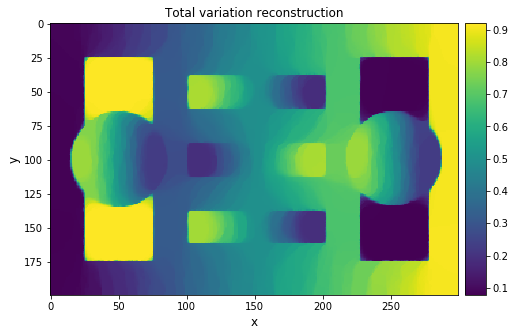

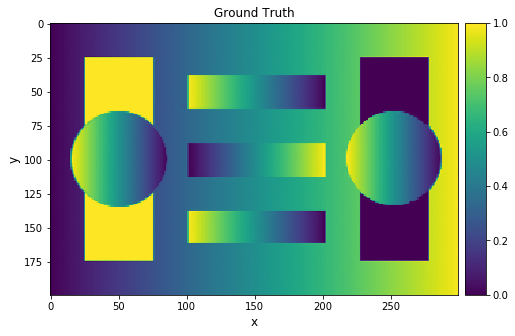

In [11]:
# Show Total variation denoising result and compared with the ground truth
tv_recon1 = pdhg.get_output()
show(tv_recon1, title = 'Total variation reconstruction')
show(data, title = 'Ground Truth')

## PDHG with BlockFramework

Now, we will describe another way of writing [ROF](#ROF) problem with this [form](#PDHG) using the __BlockFramework__.
In particular, we will use the concepts of __BlockOperator__, __BlockDataContainer__ and __BlockFunction__. In the previous demos, see [Jupyter Demos ...], we have already discussed  BlockOperator and BlockDataContainer.

### Reminder

- BlockOperator: is a "block matrix" that contains linear operators. For example, we can stack a __Gradient__ operator and an __Identity__ operator as:

$$ K = \begin{bmatrix}
\nabla\\
\mathbb{I}
\end{bmatrix}, \quad \mbox{ where } \nabla : \mathbb{R}^{n\times m} \rightarrow (\mathbb{R}^{n\times m},\mathbb{R}^{n\times m}) \mbox{ and } \mathbb{I} : \mathbb{R}^{n\times m} \rightarrow \mathbb{R}^{n\times m}
$$

Then, $ K : \mathbb{R}^{n\times m} \rightarrow ( (\mathbb{R}^{n\times m}\times \mathbb{R}^{n\times m}), \mathbb{R}^{n\times m})$, i.e.,
$$ X = \mathbb{R}^{n\times m}, \quad Y = ( (\mathbb{R}^{n\times m}\times \mathbb{R}^{n\times m}), \mathbb{R}^{n\times m})$$

Therefore

- An element $x\in X$ is a DataContainer.
- An element $y\in Y$ is a BlockDataContainer of a BlockDataContainer and a DataContainer, i.e.,

$$ K x = 
\begin{bmatrix}
\nabla x\\
\mathbb{I}x
\end{bmatrix}
= \begin{bmatrix}
\begin{bmatrix}
\partial_{y} x\\
\partial_{x} x
\end{bmatrix}\\
x
\end{bmatrix}$$


In [12]:
# Define the Identity operator
Id = Identity(ig)

# Create a BlockOperator containing the Gradient and Identity operators
K = BlockOperator(Grad, Id)

#Inspect element in the domain & range of K
x = ig.allocate()
y = K.direct(x)

print('x is a {}'.format(x.__class__.__bases__))
print('y is a {}'.format(y.__class__))

x is a (<class 'ccpi.framework.framework.DataContainer'>,)
y is a <class 'ccpi.framework.BlockDataContainer.BlockDataContainer'>


## BlockFucntion

The concept of BlockFucntion is similar to a BlockOperator and BlockDataContainer. This time, we _append_ functions as shown below:

$$ F = [f_{1}, f_{2}]$$

For example, let 

$$\begin{align}
f_{1}: Y \rightarrow \mathbb{R}, \quad f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2,1} \\
f_{2}: X \rightarrow \mathbb{R}, \quad f_{2}(z_{2}) = \frac{1}{2}\|z_{2} - g\|_{2}^{2}
\end{align}$$

and consider $z = (z_{1}, z_{2})\in Y\times X$, then 

$$F(z) : = F((x_{1},x_{2}) = f_{1}(x_{1}) + f_{2}(x_{2})$$

In a sense, $F(z)$ is a *separable sum* of decoupled functions. __So, why do we need to write in this form__? It turns out, that the proximal operator of a BlockFunction can be separated, i.e., 

$$\mathrm{prox}_{\tau F}(z) = 
\begin{bmatrix}
\mathrm{prox}_{\tau f_1}(z_1)\\
\mathrm{prox}_{\tau f_2}(z_2)
\end{bmatrix} = 
\begin{bmatrix}
\underset{w_{1}\in Y}{\operatorname{argmin}} \tau f_{1}(w_{1}) + \frac{1}{2}\|w_{1} - z_{1}\|^{2}\\
\underset{w_{2}\in X}{\operatorname{argmin}} \tau f_{2}(w_{2}) + \frac{1}{2}\|w_{2} - z_{2}\|^{2}
\end{bmatrix}
\begin{cases}
\mbox{Both of the proximal operators} \\
\mbox{have a closed form solution}
\end{cases}
$$

Finally, we define $G: X \rightarrow \mathbb{R}$, with $G(x) = 0, \forall x\in X$. Overall, for the BlockOperator K, the BlockFunction F and the function G we have:

1. $ K = \begin{bmatrix}
\nabla\\
\mathbb{I}
\end{bmatrix}
$

1. $ F(z) = [f_{1}(z_{1}), f_{2}(z_{2})] = [ \alpha\,\| z_{1} \|_{2,1}, \frac{1}{2}\| z_{2} - g \|^{2} ]$

1. $ G(u) = 0 $

In [13]:
# Define BlockFunction and fucntion G
f1 = alpha * MixedL21Norm()
f2 = 0.5 * L2NormSquared(noisy_data)
F = BlockFunction(f1, f2)

G = ZeroFunction()

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        300         0.000    1.03594e+04  -0.00000e+00    1.03594e+04
      100        300         0.002    9.38836e+03  -7.05980e+03    1.64482e+04
      200        300         0.002    7.55461e+02   7.11976e+02    4.34855e+01
      300        300         0.002    7.49605e+02   7.40141e+02    9.46455e+00

Without BlockFramework PSNR = 25.079507789228906
With BlockFramework PSNR = 25.07967587407689



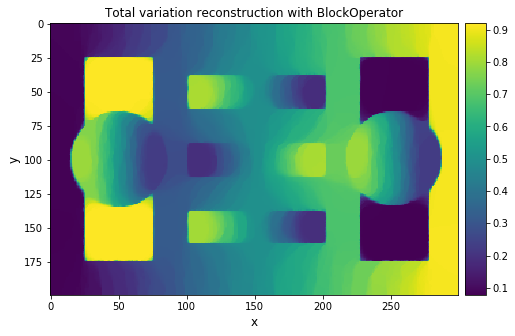

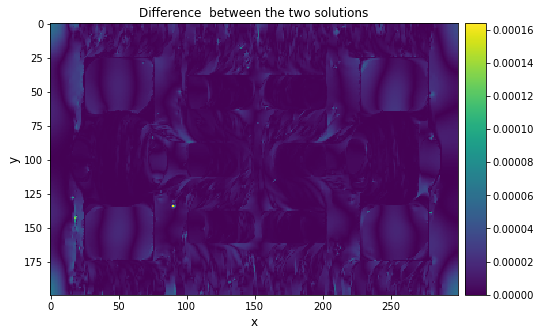

In [14]:
# The operator norm of the BlockOperator
normK = K.norm()

# Setup and run the PDHG algorithm
pdhg = PDHG(f = F, g = G, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 300, update_objective_interval = 100)
pdhg.run(verbose = True)

# Show Total variation denoising result
tv_recon2 = pdhg.get_output()
show(tv_recon2, title = 'Total variation reconstruction with BlockOperator')

# Compare the solution without the BlockFnormK = K.norm()
show((tv_recon1-tv_recon2).abs(), title = 'Difference  between the two solutions')

# Compute PSNR quality measure
PSNR1 = compare_psnr(data.as_array(), tv_recon1.as_array())
PSNR2 = compare_psnr(data.as_array(), tv_recon2.as_array())

print('\nWithout BlockFramework PSNR = {}'.format(PSNR1))
print('With BlockFramework PSNR = {}\n'.format(PSNR2))

## Exercise 1 :  Tikhonov regularisation 

In this exercise, we replace __MixedL21Norm__ of the Gradient with the  __L2NormSquared__ of the Gradient. Basically, we will solve the same minimisation problem using the __Regularised CGLS__ algorithm ( see Jupyter Demo ). In this case, we need to change only __one of the functions__ in the definition of __BlockFunction F__.

In [15]:
# Define the L2NormSquared

    ### START CODE HERE ### 
    
    # f1 = ... 
    
    ### END CODE HERE ###
    
# Define a BlockFunction F

    ### START CODE HERE ### 
    
    # F = ... 
    
    ### END CODE HERE ###    
    
# Run PDHG

    ### START CODE HERE ### 

    # pdhg = ...
    # pdhg
    
# Show Tikhonov reconstruction and compared with Total Variation    

    ### START CODE HERE ### 

    # tikhonov_recon = ... 
    # show(tikhonov_recon)
    # show(tv_recon2)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        300         0.000    1.03594e+04  -0.00000e+00    1.03594e+04
      100        300         0.002    9.12693e+03  -7.05980e+03    1.61867e+04
      200        300         0.002    6.61606e+02   6.61495e+02    1.10787e-01
      300        300         0.002    6.61606e+02   6.61603e+02    2.75693e-03


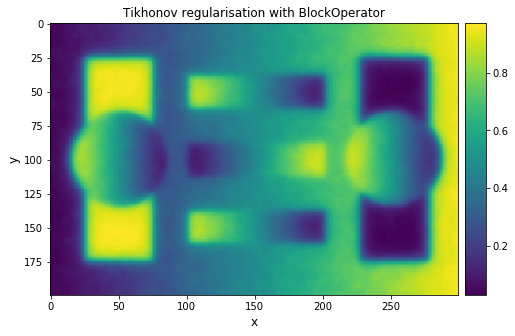

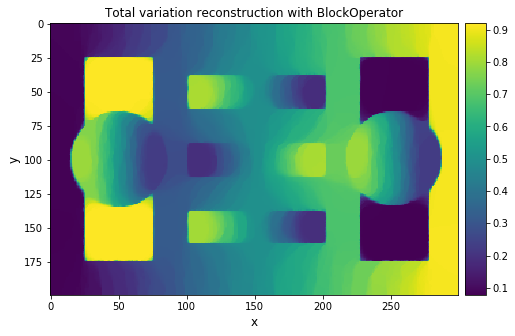

In [16]:
f1 = 5 * L2NormSquared()
F = BlockFunction(f1, f2)

# Setup and run the PDHG algorithm
pdhg = PDHG(f = F, g = G, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 300, update_objective_interval = 100)
pdhg.run(verbose = True)

# Show Tikhonov reconstruction and compared with Total Variation
tikhonov_recon = pdhg.get_output()
show(tikhonov_recon, title = 'Tikhonov regularisation with BlockOperator')
show(tv_recon2, title = 'Total variation reconstruction with BlockOperator')

# Exercise 2

In this exercise, we run the PDHG algorith with the BlockFramework to denoise a __color__ image corrupted with "Salt & Pepper Noise" and a Total variation regulariser.

1. Load a color image from TestData: PEPPERS. We can replace [here](#TestData) the _SHAPES_ argument with _PEPPERS_ and select _noise='s&p'_.
1. Setup PDHG with the Block framework. For this kind of noise, a suitable data-fitting term is the L1Norm.
1. Note, that we need to find an __optimal__ regularising parameter. So we have to loop over possible candidates of regularising parameters and allocate space to store all these different reconstructions, i.e.,

    alpha = [0.01, 0.05, 0.1, 0.3, 0.5]
    
    recon = np.zeros((len(alpha),) + ig.shape)
    
    for i in range(len(alpha)):
    
        ## Add you code here and change regularising parameters as
        f1 = alpha[i] * MixedL21Norm()
        
1. Follow the steps below and in the next cell the solution is presented. However, we intentionally changed two lines, can you find the problem?

In [17]:
# Load Color image: PEPPERS, 

    ### START CODE HERE ### 
    
    # data = ... 
    
    ### END CODE HERE ###
    
# Get geometry of data    

    ### START CODE HERE ### 
    
    # ig = ... 
    
    ### END CODE HERE ###
    
# Add salt and pepper noise    

    ### START CODE HERE ### 
    
    # n1 = ... 
    
    ### END CODE HERE ### 
    
# Allocate space for noisy_data and fill it   

    ### START CODE HERE ### 
    
    # noisy_data = ...
    # noisy_data... 
    
    ### END CODE HERE ###     
    
# Define BlockOperator with Gradient and Identity

    ### START CODE HERE ### 
    
    # Grad = ...
    # Id = ...
    # K = ...

    ### END CODE HERE ### 
    
# Define BlockFunction F of functions f1, f2. G is a ZeroFunction.

    ### START CODE HERE ### 
    
    # f1 = ...
    # f2 = ...
    # F = ...
    # G = ...

    ### END CODE HERE ###  
    
# Define primal/dual stepsizes for sigma/tau using operator norm of K operator. Note, that sigma*tau*||K||^{2}<1

    ### START CODE HERE ### 
    
    # normK = ...
    # sigma = ...
    # tau = ...

    ### END CODE HERE ###     

    
# Run PDHG

    ### START CODE HERE ### 

    # pdhg 
    # pdhg 
    # recon[i] = pdhg.get_output()

### END CODE HERE ### 

In [34]:
######## Solution for Exercise 2 ########

# Load Color image: PEPPERS
    
### START CODE HERE ### 

loader = TestData(data_dir=os.path.join(sys.prefix, 'share','ccpi'))
data = loader.load(TestData.PEPPERS, size=(256,256))

### END CODE HERE ###

# Get geometry of data    

### START CODE HERE ### 

ig = data.geometry

### END CODE HERE ###    

# Add salt and pepper noise    

### START CODE HERE ### 

n1 = TestData.random_noise(data.as_array(), mode = 's&p', salt_vs_pepper = 0.9, amount=0.2)
noisy_data = ig.allocate()
noisy_data.fill(n1)

### END CODE HERE ### 

# Define BlockOperator with Gradient and Identity

### START CODE HERE ### 

Grad = Gradient(ig, correlation = 'Space')
Id = Identity(ig)
K = BlockOperator(Grad, Id)

### END CODE HERE ### 

# Define BlockFunction F of functions f1, f2. G is a ZeroFunction.

### START CODE HERE ### 

alpha = [0.1, 0.5, 1, 5]
recon = np.zeros((len(alpha),) + ig.shape)

# Allocate space for all the reconstuctions with different regularising parameters

for i in range(len(alpha)):
    
    f1 = alpha[i] * MixedL21Norm()
    f2 = L1Norm(noisy_data)
    F = BlockFunction(f1, f2)
    G = ZeroFunction()

    ### END CODE HERE ### 

    # Define primal/dual stepsizes for sigma/tau using operator norm of K operator. Note, that sigma*tau*||K||^{2}<1

    ### START CODE HERE ### 

    normK = K.norm()
    sigma = 1
    tau = 1/(sigma*normK**2)

    ### END CODE HERE ###  

    # Run PDHG

    # ### START CODE HERE ### 

    # Setup and run the PDHG algorithm
    pdhg = PDHG(f = F, g = G, operator = K, sigma = sigma, tau = tau, 
                max_iteration = 200, update_objective_interval = 100)
    pdhg.run(verbose = True)
    recon[i] = pdhg.get_output().as_array()
        

<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=512x512 at 0x7F0331A48208>
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    1.09610e+05  -0.00000e+00    1.09610e+05
      100        200         0.005    9.79290e+04  -2.67829e+04    1.24712e+05
      200        200         0.004    6.54756e+03   6.39618e+03    1.51379e+02
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    1.09610e+05  -0.00000e+00    1.09610e+05
      100        200         0.006    1.00844e+05  -2.67829e+04    1.27627e+05
      200        200         0.006    2.46652e+04   2.42362e+04    4.29026e+02
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/It

In [46]:
stack_recon = ImageData(recon)
islicer(recon, 0, title = 'Parameter alpha = {}'.format(alpha), minmax=[0,1])


# z1 = islicer(, 0, title = 'Parameter alpha = {}'.format(alpha), minmax=[0,1])
# from utilities import link_islicer
# link_islicer(recon[0], recon[1])

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=3), Output()), _dom_cla…

TypeError: Each object must be HasTraits, not <class 'numpy.ndarray'>

<h1><center>End of Part I </center></h1>

In this Demo, we presented the PDHG algorithm and use it to denoise images gray and colored images under Gaussian and Salt & Pepper noise. We use two different regularisers 

and with Tikhonov and Total variation reglarisers. In particular, we learn how to define all t





For the case of Poisson noise and Total Generalised Variation, we suggest the reader to 

## References

1.
1